# Import Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

plt.rcParams.update({'font.size':12})

# load Data

In [2]:
data = pd.read_csv("covid_19_data.csv", parse_dates = ['ObservationDate', 'Last Update'])

print(data.shape)
print('Last update:' + str(data.ObservationDate.max()))

(59759, 8)
Last update:2020-07-08 00:00:00


# Cleaning Data 

In [3]:
data = data[(data.Confirmed>0) | (data['Province/State'] == 'Recovered') | (data.Recovered > 0)]
data = data.drop(['SNo', "Last Update"], axis=1)
data = data.rename(columns={"Country/Region": "Country", "ObservationDate":"Date"})

data.isnull().sum()

Date                  0
Province/State    22363
Country               0
Confirmed             0
Deaths                0
Recovered             0
dtype: int64

In [4]:
data = data.sort_values(['Date', 'Country', 'Province/State'])

data['first_date'] = data.groupby('Country')['Date'].transform('min')
data['days'] = (data['Date'] - data['first_date']).dt.days

In [5]:
data.head(10)

,Date,Province/State,Country,Confirmed,Deaths,Recovered,first_date,days
35,2020-01-22,NaN,Japan,2.0,0.0,0.0,2020-01-22,0
20,2020-01-22,Macau,Macau,1.0,0.0,0.0,2020-01-22,0
0,2020-01-22,Anhui,Mainland China,1.0,0.0,0.0,2020-01-22,0
1,2020-01-22,Beijing,Mainland China,14.0,0.0,0.0,2020-01-22,0
2,2020-01-22,Chongqing,Mainland China,6.0,0.0,0.0,2020-01-22,0
3,2020-01-22,Fujian,Mainland China,1.0,0.0,0.0,2020-01-22,0
5,2020-01-22,Guangdong,Mainland China,26.0,0.0,0.0,2020-01-22,0
6,2020-01-22,Guangxi,Mainland China,2.0,0.0,0.0,2020-01-22,0
7,2020-01-22,Guizhou,Mainland China,1.0,0.0,0.0,2020-01-22,0
8,2020-01-22,Hainan,Mainland China,4.0,0.0,0.0,2020-01-22,0


# Latest status update

In [6]:
latest = data[data.Date == data.Date.max()]
print("Total confirmed cases: %.d" %np.sum(latest['Confirmed']))
print('Total death cases: %.d' %np.sum(latest['Deaths']))
print('Total recovered cases: %.d' %np.sum(latest['Recovered']))
print('Death rate %%: %.2f' % (np.sum(latest['Deaths'])/np.sum(latest['Confirmed'])*100))

Total confirmed cases: 12041480
Total death cases: 549467
Total recovered cases: 6586726
Death rate %: 4.56


In [7]:
 data.describe()

,Confirmed,Deaths,Recovered,days
count,59439.000000,59439.000000,59439.000000,59439.000000
mean,9357.326116,533.706439,4057.225122,91.514898
std,29412.017707,2474.381236,22772.574997,44.316668
min,0.000000,0.000000,0.000000,0.000000
25%,92.000000,1.000000,0.000000,57.000000
50%,855.000000,13.000000,101.000000,97.000000
75%,4625.000000,146.000000,1195.000000,127.000000
max,405843.000000,41128.000000,953420.000000,168.000000


In [8]:
cty = latest.groupby('Country').sum()
cty['Death Rate'] = cty['Deaths'] / cty['Confirmed'] * 100
cty['Recovery Rate'] = cty['Recovered'] / cty['Confirmed'] * 100
cty['Active'] = cty['Confirmed'] - cty['Deaths'] - cty['Recovered']
cty.drop('days',axis=1).sort_values("Confirmed", ascending=False).head(10)

,Confirmed,Deaths,Recovered,Death Rate,Recovery Rate,Active
Country,,,,,,
US,3054699.0,132300.0,953420.0,4.331032,31.211586,1968979.0
Brazil,1713160.0,67964.0,1139844.0,3.967172,66.534591,505352.0
India,767296.0,21129.0,476378.0,2.753696,62.085297,269789.0
Russia,699749.0,10650.0,471718.0,1.521974,67.412458,217381.0
Peru,312911.0,11133.0,204748.0,3.557881,65.433302,97030.0
Chile,303083.0,6573.0,271741.0,2.168713,89.658938,24769.0
UK,288511.0,44602.0,1378.0,15.459376,0.477625,242531.0
Mexico,275003.0,32796.0,214316.0,11.925688,77.932241,27891.0
Spain,252513.0,28396.0,150376.0,11.245362,59.551785,73741.0


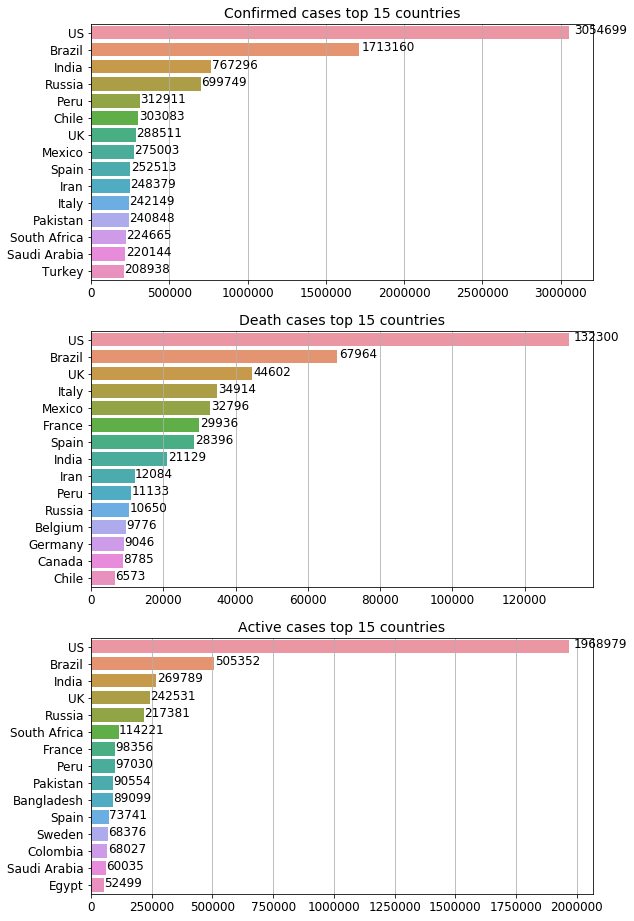

In [9]:
def plot_new(column, title):
    _ = cty.sort_values(column, ascending=False).head(15)
    g = sns.barplot(_[column], _.index)
    plt.title(title, fontsize=14)
    plt.ylabel(None)
    plt.xlabel(None)
    plt.grid(axis="x")
    for i, v in enumerate(_[column]):
        if column == 'Death Rate':
            g.text(v*1.01, i+0.2, str(round(v,2)))
        else:
            g.text(v*1.01, i+0.1, str(int(v)))

plt.figure(figsize=(9,16))
plt.subplot(311)
plot_new('Confirmed', 'Confirmed cases top 15 countries')
plt.subplot(312)
plot_new('Deaths', 'Death cases top 15 countries')
plt.subplot(313)
plot_new('Active', 'Active cases top 15 countries')

plt.show()

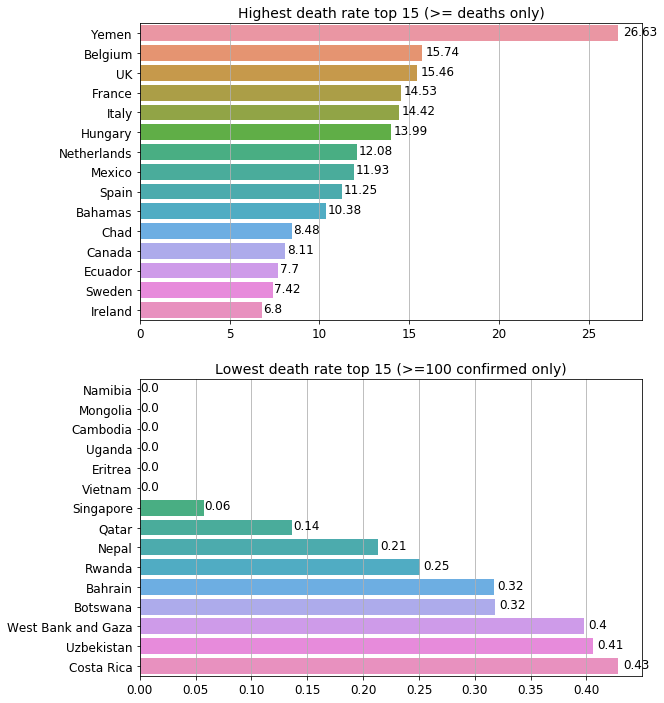

In [10]:
def plot_rate(rank, title):
    if rank == 'highest':
        _ = cty[cty.Deaths>=10].sort_values('Death Rate', ascending=False).head(15)
    else:
        _ = cty [cty.Confirmed>=100].sort_values('Death Rate').head(15)
    g = sns.barplot(_['Death Rate'], _.index)
    plt.title(title, fontsize=14)
    plt.ylabel(None)
    plt.xlabel(None)
    plt.grid(axis='x')
    for i, v in enumerate(_['Death Rate']):
        g.text(v*1.01, i+0.1, str(round(v,2)))
    
plt.figure(figsize=(9,12))
plt.subplot(211)
plot_rate('highest', 'Highest death rate top 15 (>= deaths only)')
plt.subplot(212)
plot_rate('lowest', 'Lowest death rate top 15 (>=100 confirmed only)')
    

# Evolution of cases

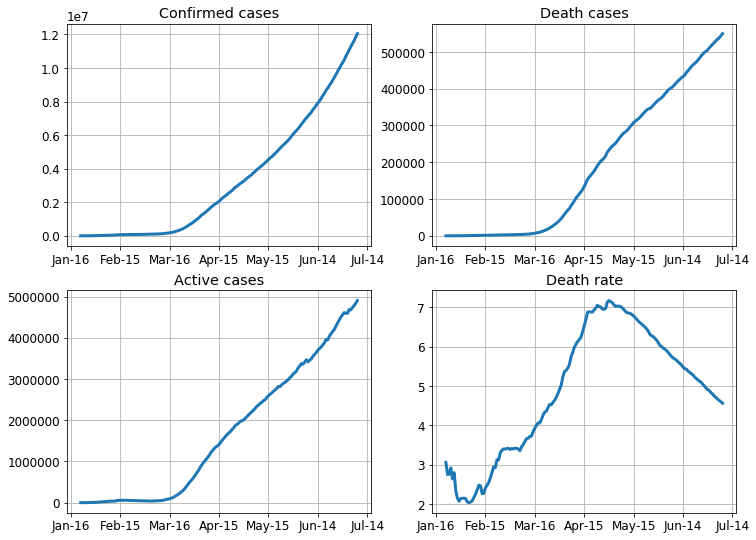

In [15]:
import matplotlib.dates as mdates
months_fmt = mdates.DateFormatter('%b-%e')

evo = data.groupby('Date')[['Confirmed', 'Deaths', 'Recovered']].sum()
evo['Active']= evo['Confirmed'] - evo ['Deaths'] - evo['Recovered']
evo['Death Rate']= evo['Deaths'] / evo['Confirmed'] * 100
evo['Recover Rate']= evo['Recovered'] / evo['Confirmed'] * 100

fig, ax = plt.subplots(2, 2, figsize=(12, 9))

def plot_evo(num, col, title):
    ax[num].plot(evo[col], lw=3)
    ax[num].set_title(title)
    ax[num].xaxis.set_major_locator(plt.MaxNLocator(7))
    ax[num].xaxis.set_major_formatter(months_fmt)
    ax[num].grid(True)

plot_evo((0,0), 'Confirmed', 'Confirmed cases')
plot_evo((0,1), 'Deaths', 'Death cases')
plot_evo((1,0), 'Active', 'Active cases')
plot_evo((1,1), 'Death Rate', 'Death rate')

plt.show()

In [16]:
def plot_cty(num, evo_col, title):
    ax[num].plot(evo_col, lw=3)
    ax[num].set_title(title)
    ax[num].xaxis.set_major_locator(plt.MaxNLocator(7))
    ax[num].xaxis.set_major_formatter(months_fmt)
    ax[num].grid(True)

def evo_cty(country):
    evo_cty = data[data.Country==country].groupby('Date')[['Confirmed', 'Deaths','Recovered']].sum()
    evo_cty['Active'] = evo_cty['Confirmed'] - evo_cty['Deaths'] - evo_cty['Recovered']
    evo_cty['Death Rate'] = evo_cty['Deaths'] / evo_cty['Confirmed'] * 100
    plot_cty((0,0), evo_cty['Confirmed'], 'Confirmed cases')
    plot_cty((0,1), evo_cty['Deaths'], 'Death cases')
    plot_cty((1,0), evo_cty['Active'], 'Active cases')
    plot_cty((1,1), evo_cty['Death Rate'], 'Death rate')
    fig.suptitle(country, fontsize=16)

plt.show()
    

# ASIA

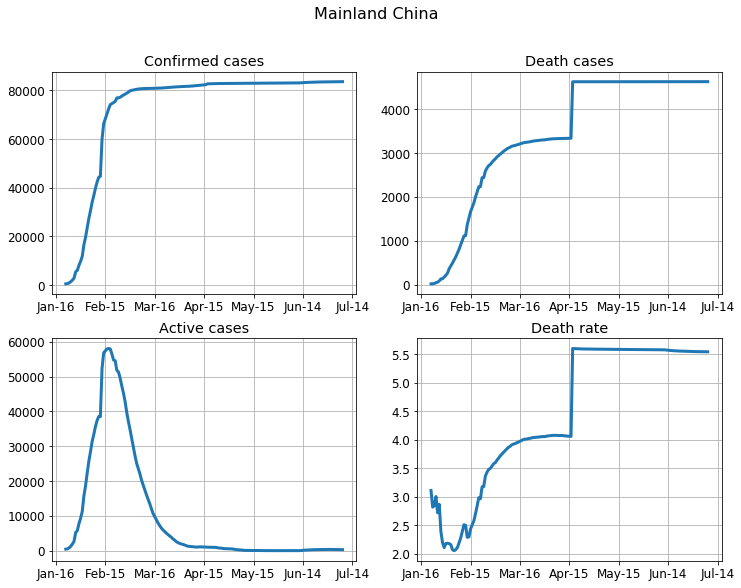

In [17]:
fig, ax = plt.subplots(2, 2, figsize=(12, 9))
evo_cty('Mainland China')

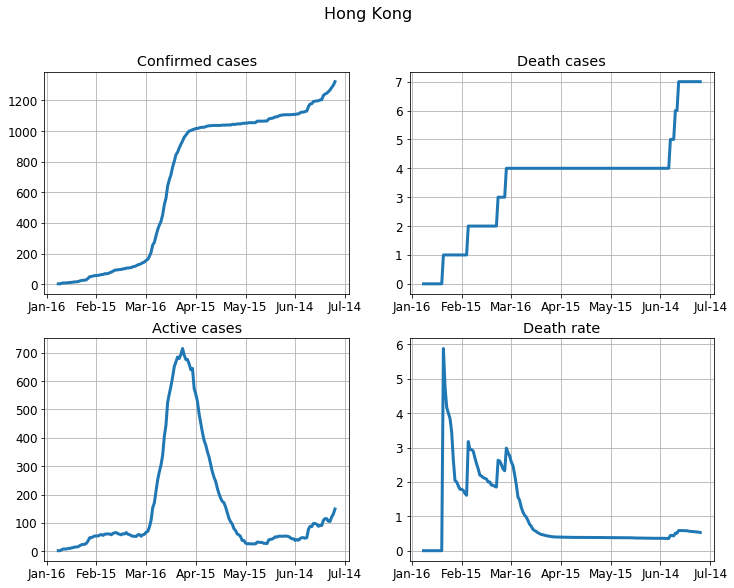

In [18]:
fig, ax = plt.subplots(2, 2, figsize=(12, 9))
evo_cty('Hong Kong')

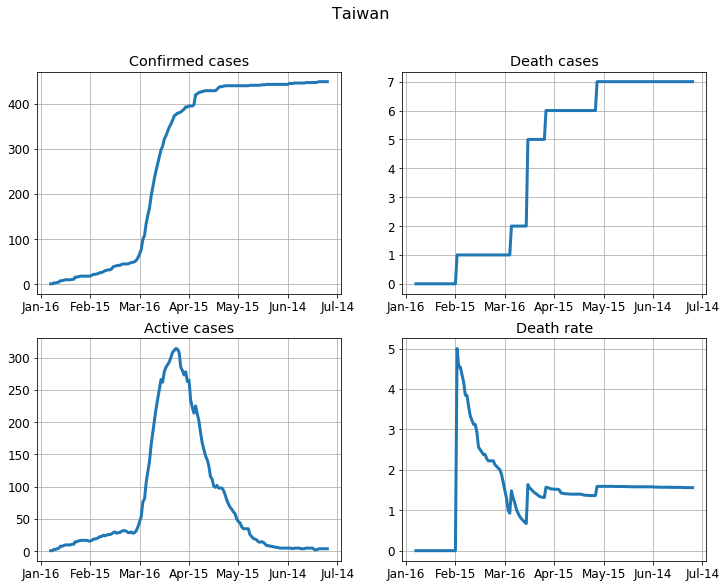

In [19]:
fig, ax = plt.subplots(2, 2, figsize=(12, 9))
evo_cty('Taiwan')

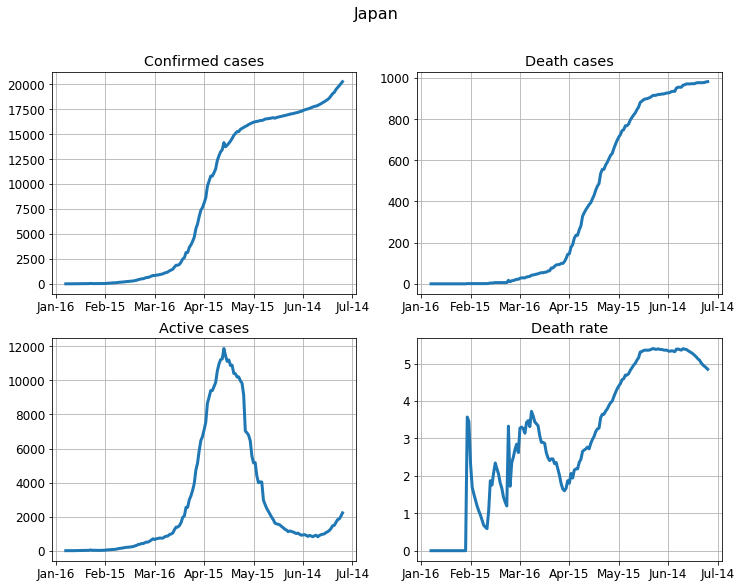

In [20]:
fig, ax = plt.subplots(2, 2, figsize=(12, 9))
evo_cty('Japan')

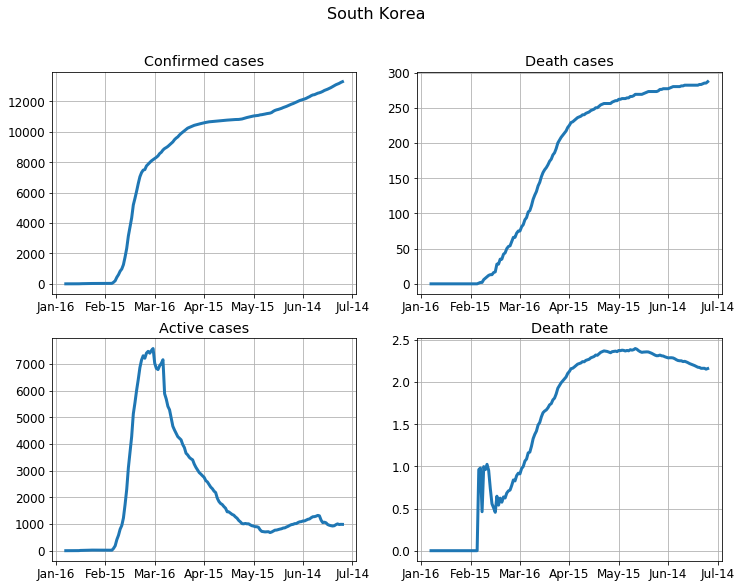

In [21]:
fig, ax = plt.subplots(2, 2, figsize=(12, 9))
evo_cty('South Korea')

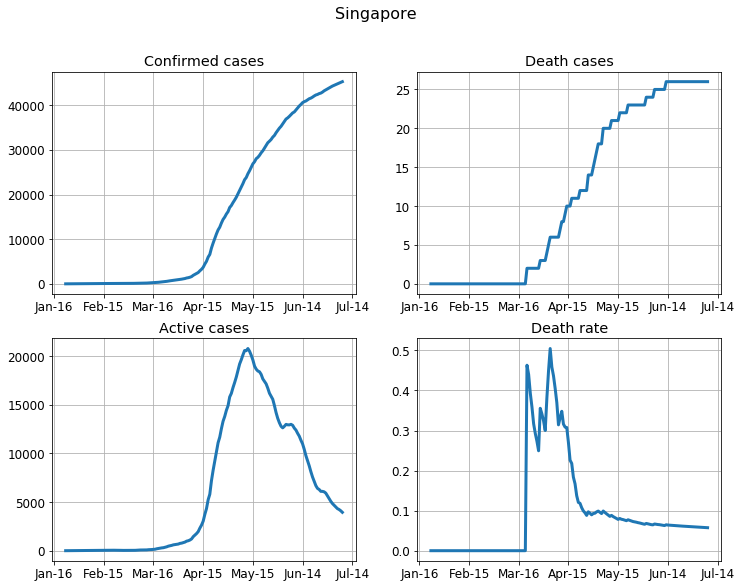

In [22]:
fig, ax = plt.subplots(2, 2, figsize=(12, 9))
evo_cty('Singapore')

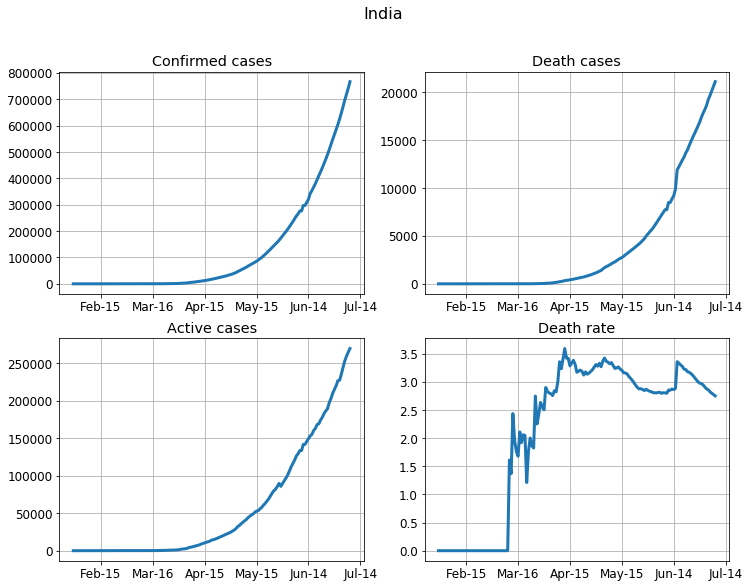

In [23]:
fig, ax = plt.subplots(2, 2, figsize=(12, 9))
evo_cty('India')

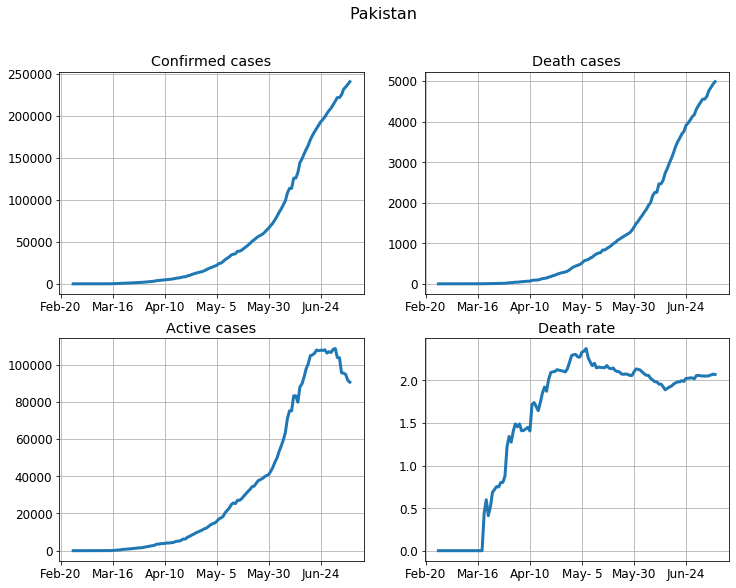

In [24]:
fig, ax = plt.subplots(2, 2, figsize=(12, 9))
evo_cty('Pakistan')

# Europe

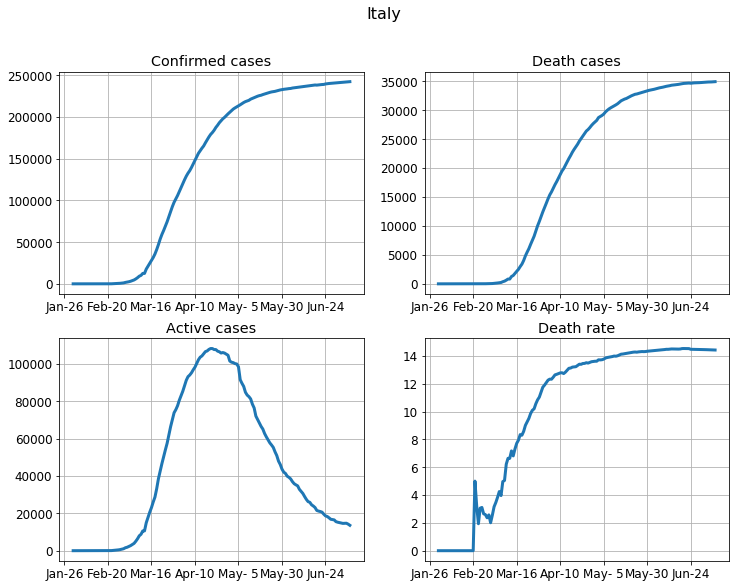

In [25]:
fig, ax = plt.subplots(2, 2, figsize=(12, 9))
evo_cty('Italy')

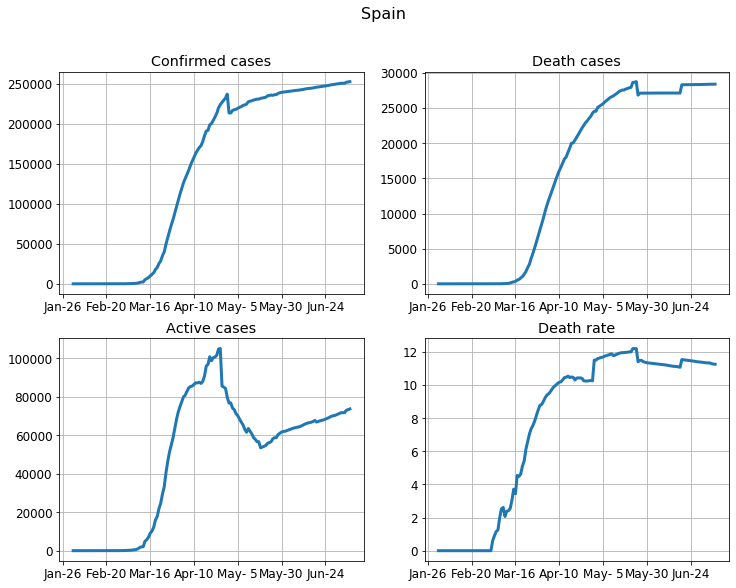

In [26]:
fig, ax = plt.subplots(2, 2, figsize=(12, 9))
evo_cty('Spain')

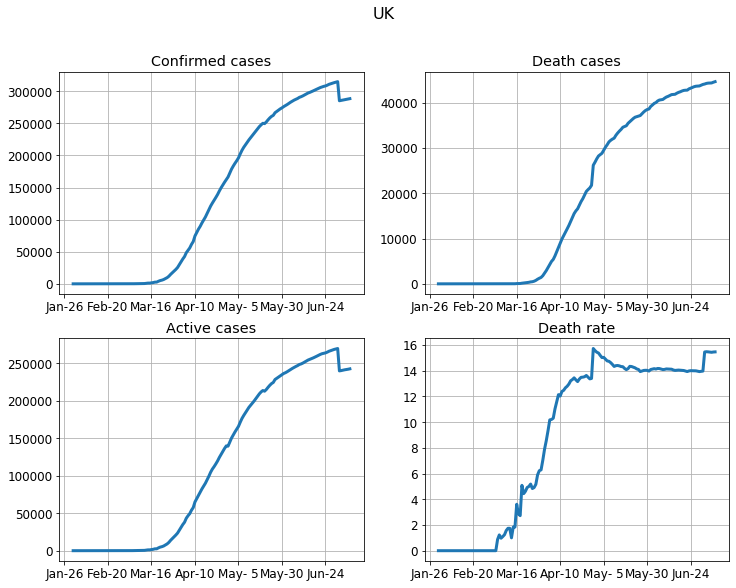

In [27]:
fig, ax = plt.subplots(2, 2, figsize=(12, 9))
evo_cty('UK')

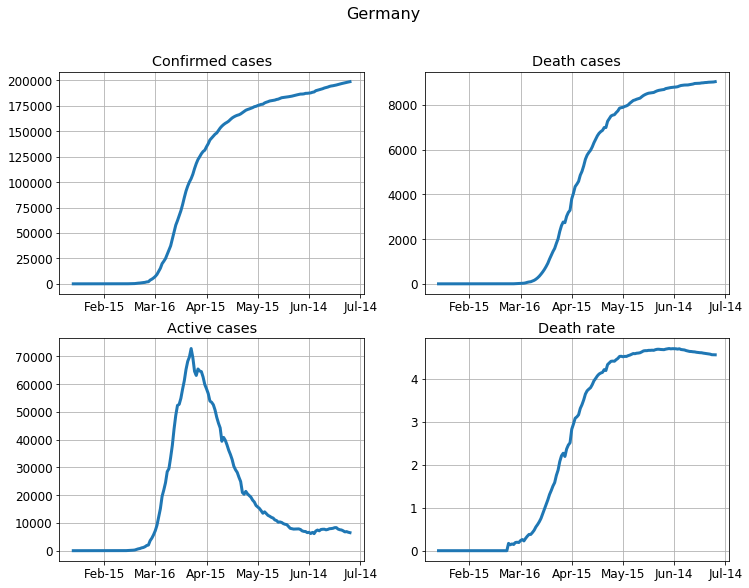

In [28]:
fig, ax = plt.subplots(2, 2, figsize=(12, 9))
evo_cty('Germany')

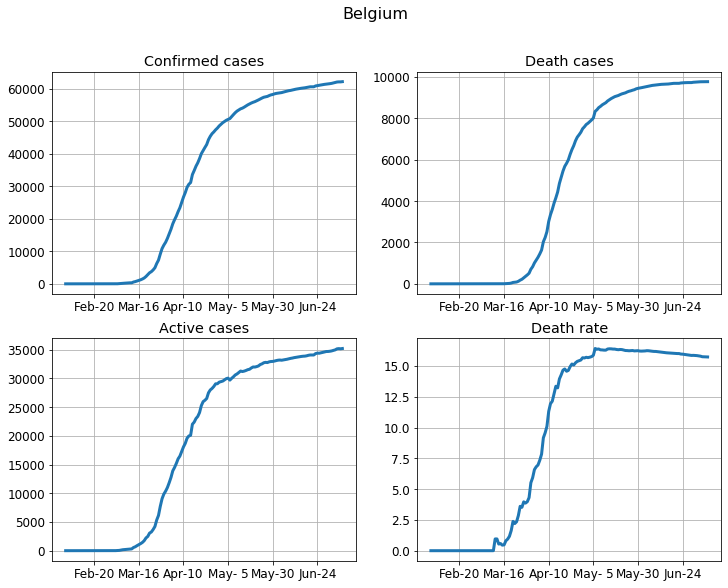

In [29]:
fig, ax = plt.subplots(2, 2, figsize=(12, 9))
evo_cty('Belgium')

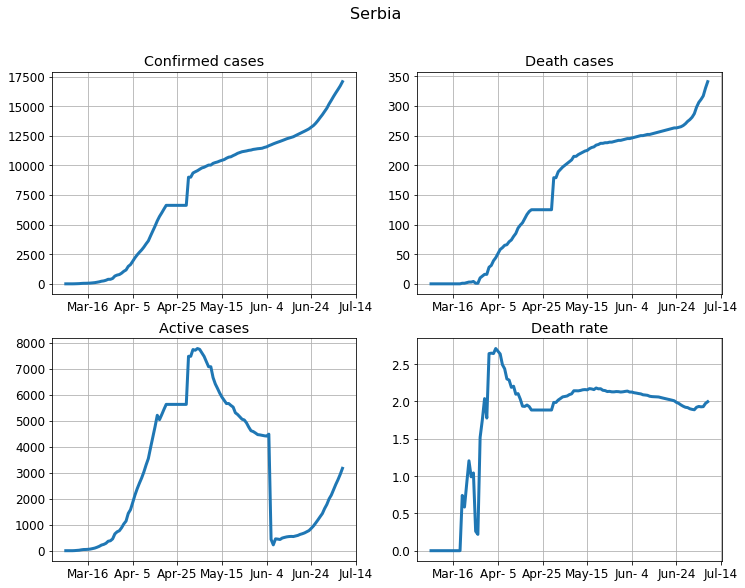

In [30]:
fig, ax = plt.subplots(2, 2, figsize=(12, 9))
evo_cty('Serbia')

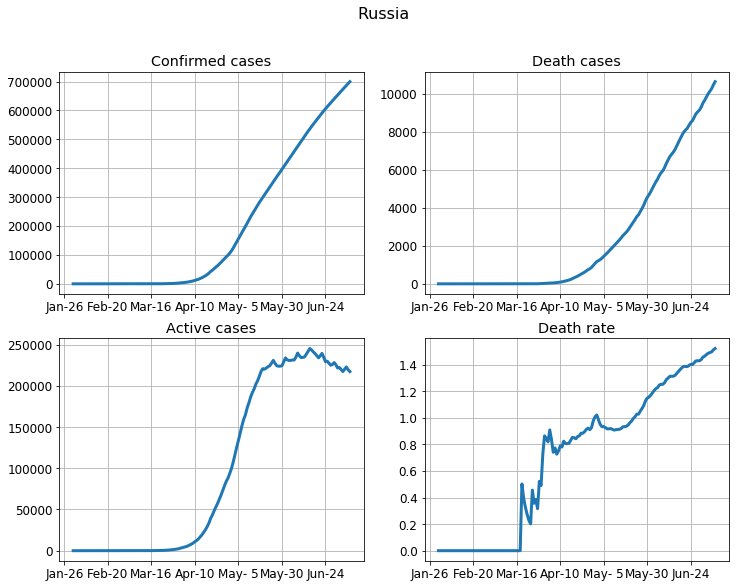

In [31]:
fig, ax = plt.subplots(2, 2, figsize=(12, 9))
evo_cty('Russia')

# America

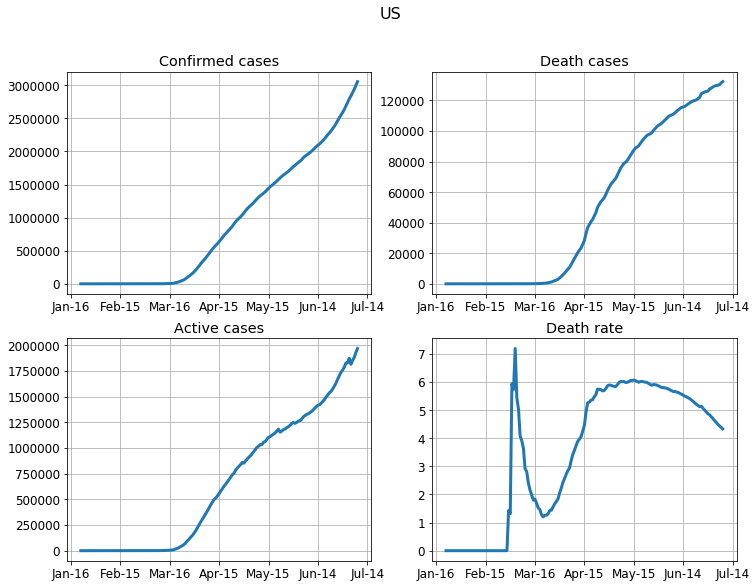

In [32]:
fig, ax = plt.subplots(2, 2, figsize=(12, 9))
evo_cty('US')

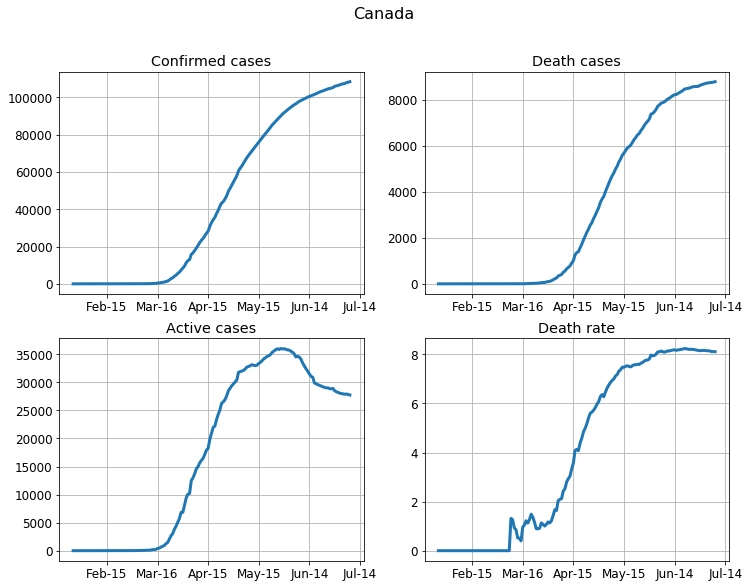

In [33]:
fig, ax = plt.subplots(2, 2, figsize=(12, 9))
evo_cty('Canada')

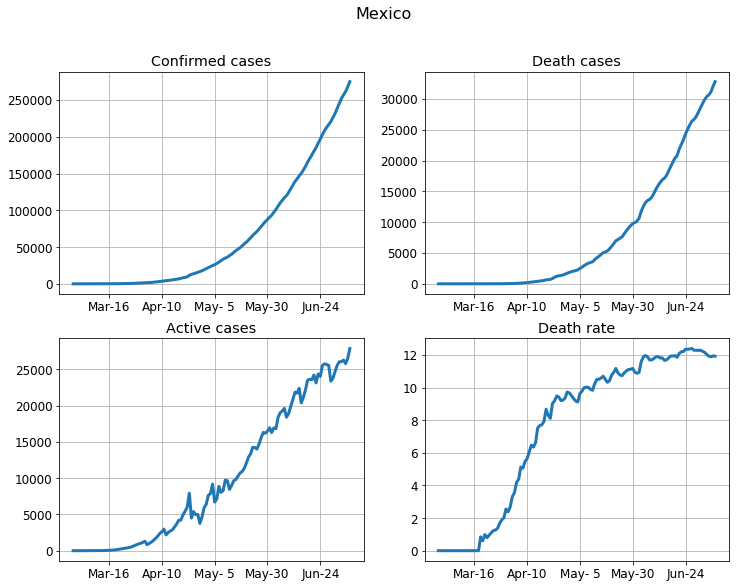

In [34]:
fig, ax = plt.subplots(2, 2, figsize=(12, 9))
evo_cty('Mexico')

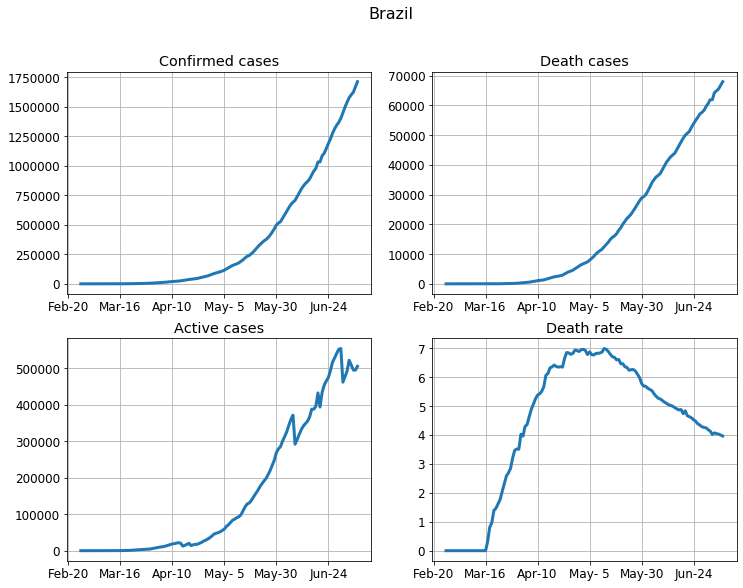

In [35]:
fig, ax = plt.subplots(2, 2, figsize=(12, 9))
evo_cty('Brazil')

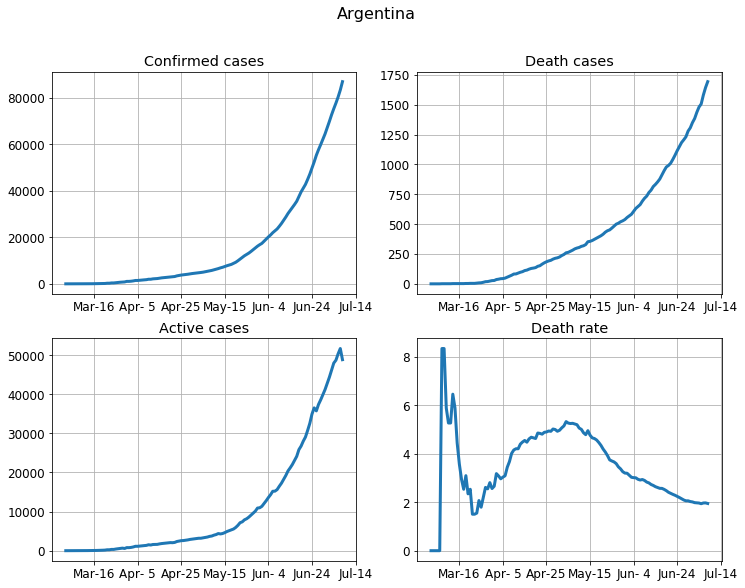

In [36]:
fig, ax = plt.subplots(2, 2, figsize=(12, 9))
evo_cty('Argentina')

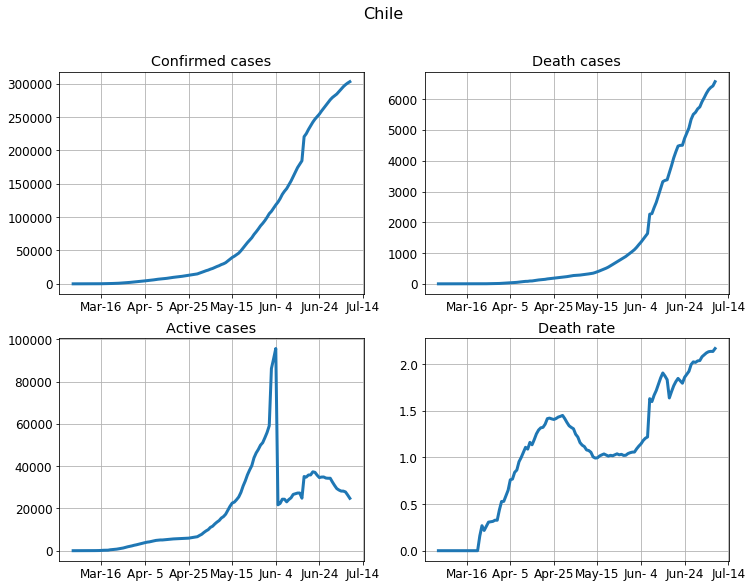

In [37]:
fig, ax = plt.subplots(2, 2, figsize=(12, 9))
evo_cty('Chile')

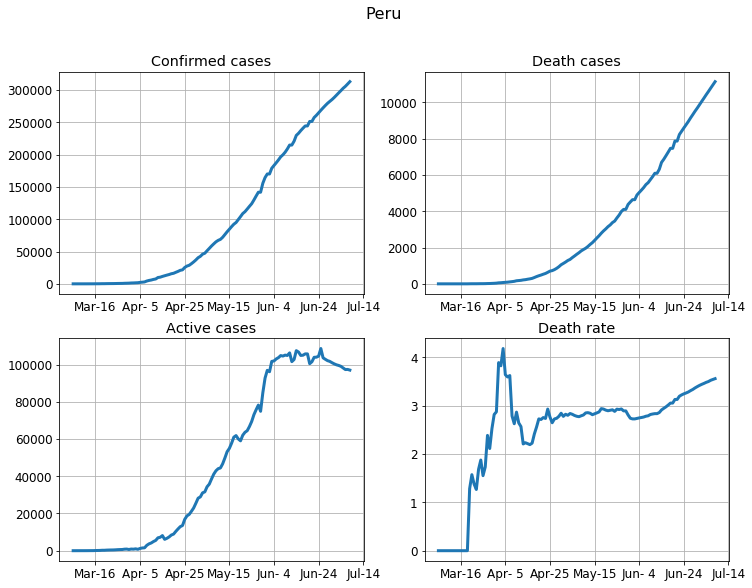

In [38]:
fig, ax = plt.subplots(2, 2, figsize=(12, 9))
evo_cty('Peru')

# Middle East

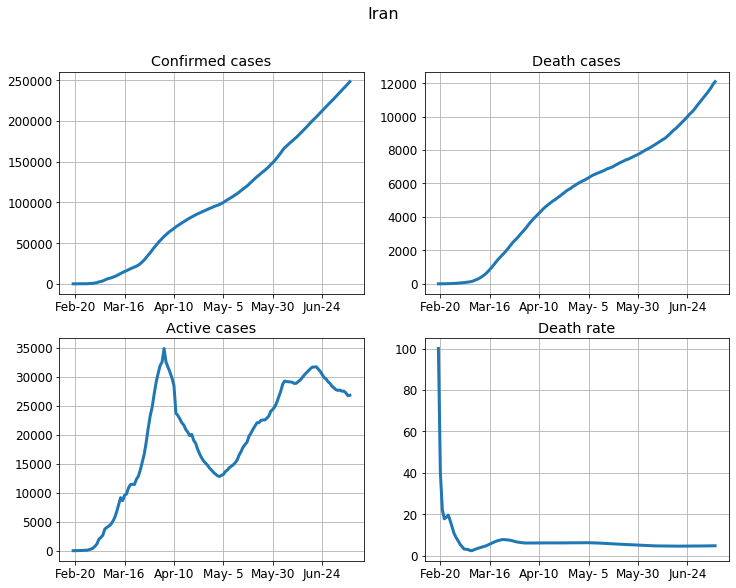

In [39]:
fig, ax = plt.subplots(2, 2, figsize=(12, 9))
evo_cty('Iran')

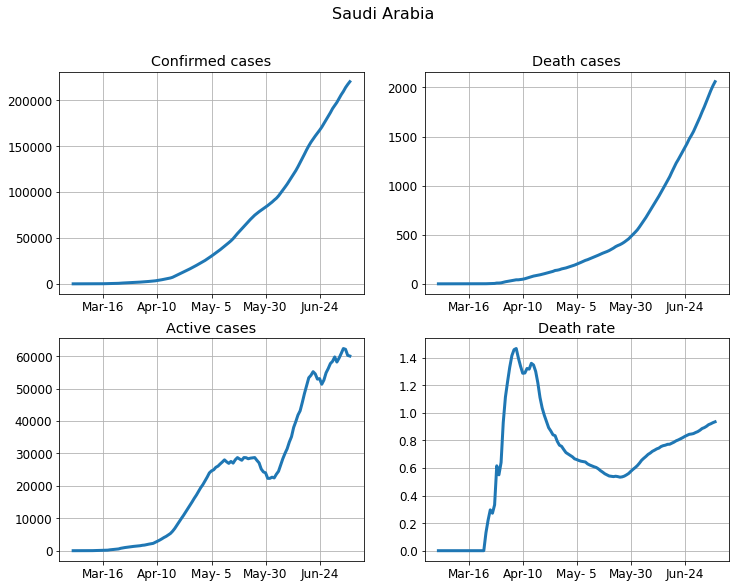

In [40]:
fig, ax = plt.subplots(2, 2, figsize=(12, 9))
evo_cty('Saudi Arabia')

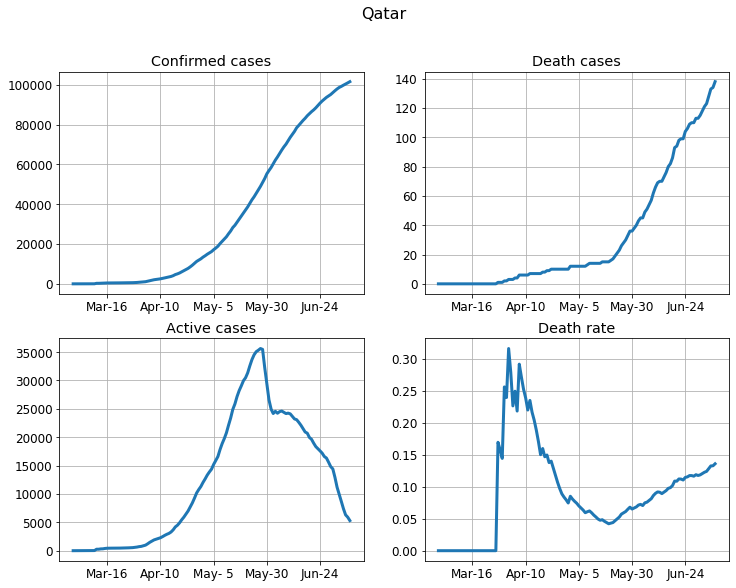

In [41]:
fig, ax = plt.subplots(2, 2, figsize=(12, 9))
evo_cty('Qatar')

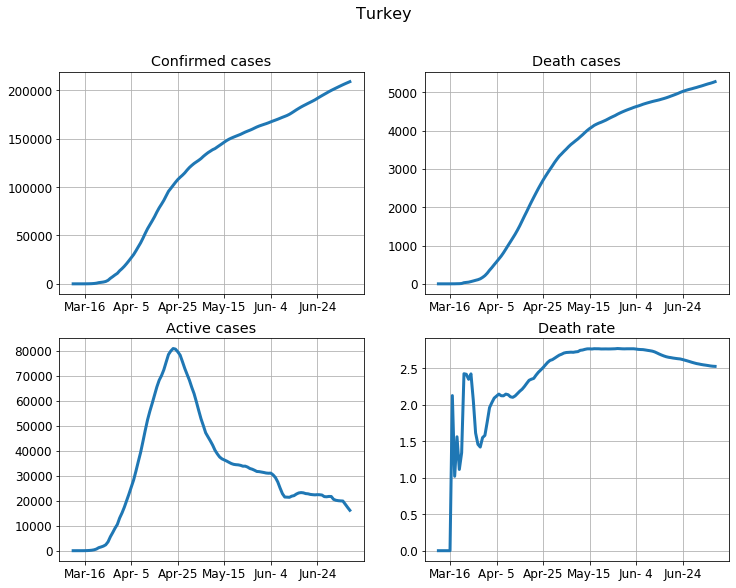

In [42]:
fig, ax = plt.subplots(2, 2, figsize=(12, 9))
evo_cty('Turkey')

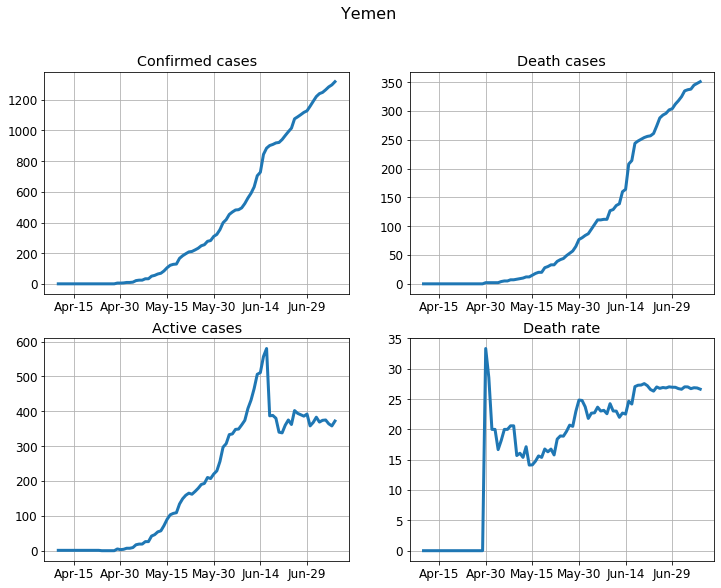

In [43]:
fig, ax = plt.subplots(2, 2, figsize=(12, 9))
evo_cty('Yemen')

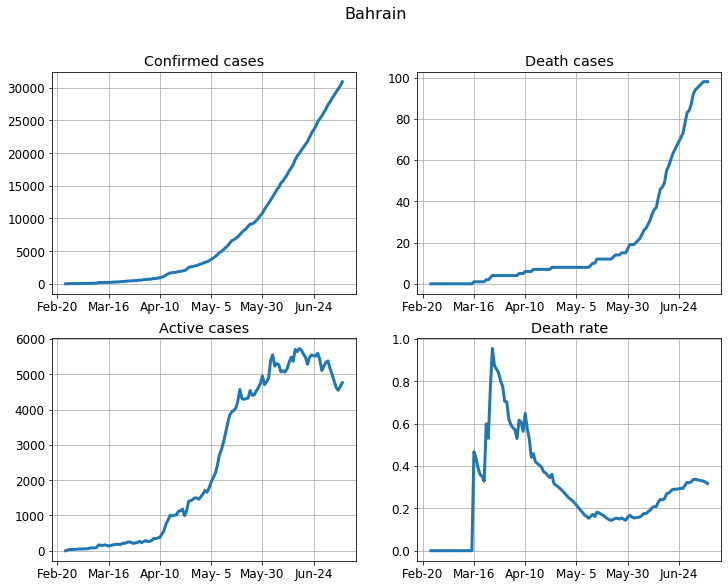

In [44]:
fig, ax = plt.subplots(2, 2, figsize=(12, 9))
evo_cty('Bahrain')

# Africa

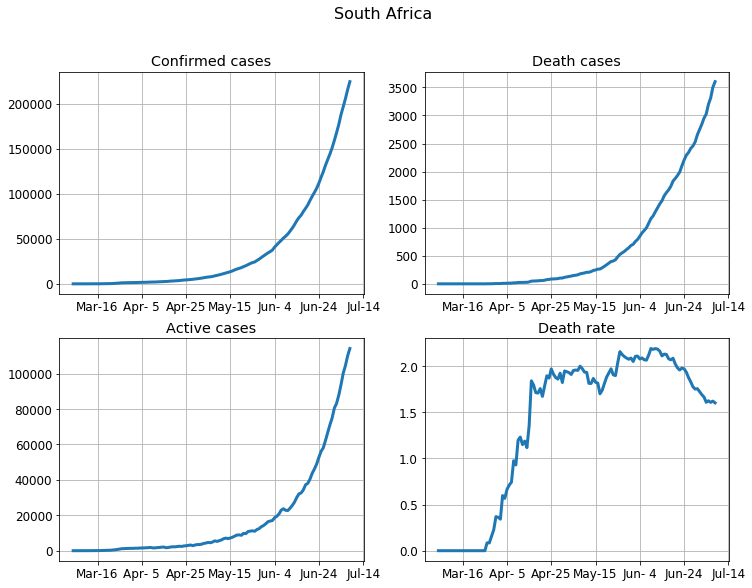

In [45]:
fig, ax = plt.subplots(2, 2, figsize=(12, 9))
evo_cty('South Africa')

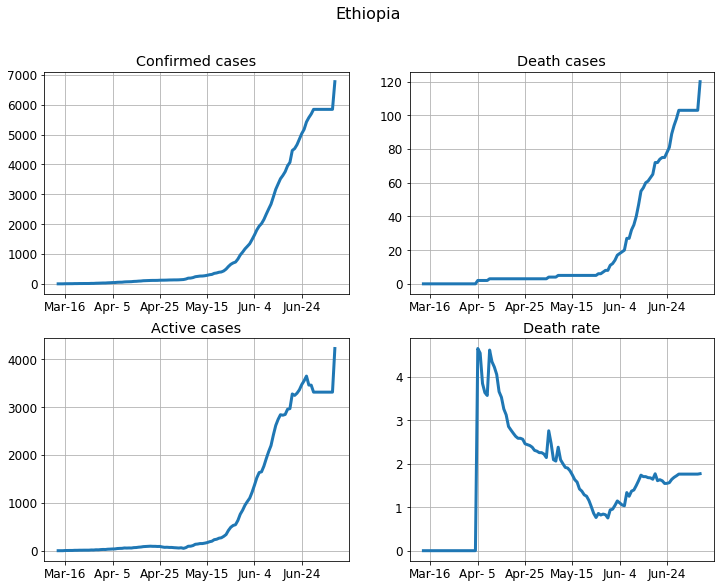

In [46]:
fig, ax = plt.subplots(2, 2, figsize=(12, 9))
evo_cty('Ethiopia')

# Population and Density

In [47]:
pop = pd.read_csv('population_by_country_2020.csv',
                 usecols = ['Country (or dependency)', 'Population (2020)', 'Density (P/Km²)'])
pop.columns = ['Country', 'Population', 'Density']
#Clean up country names
to_replace = ['China', 'United States', 'DR Congo', 'United Kingdom', 'Myanmar',"Côte d\'Ivoire", 'Czech Republic (Czechia)', 'Congo', 'Macao', 'State of Palestine', 'St. Vincent & Grenadines', 'Saint Kitts & Nevis']
replace_by = ['Mainland China', 'US', 'Congo (Kinshasa)', 'UK', 'Burma', 'Ivory Coast', 'Czech Republic', 'Congo (Brazzaville)', 'Macau', 'West Bank and Gaza', 'Saint Vincent and the Grenadines', 'Saint Kitts and Nevis']
pop.replace(to_replace, replace_by, inplace=True)

In [48]:
pop.head()

,Country,Population,Density
0,Mainland China,1438207241,153
1,India,1377233523,464
2,US,330610570,36
3,Indonesia,272931713,151
4,Pakistan,219992900,287


In [49]:
cty_p = cty.reset_index()
cty_p = cty_p.merge(pop, how='left', on = 'Country')
cty_p.head()

,Country,Confirmed,Deaths,Recovered,days,Death Rate,Recovery Rate,Active,Population,Density
0,Afghanistan,33594.0,936.0,20700.0,135,2.786212,61.618146,11958.0,38742911.0,60.0
1,Albania,3106.0,83.0,1791.0,121,2.672247,57.662589,1232.0,2878420.0,105.0
2,Algeria,17348.0,978.0,12329.0,134,5.637537,71.068711,4041.0,43685618.0,18.0
3,Andorra,855.0,52.0,802.0,128,6.081871,93.801170,1.0,77240.0,164.0
4,Angola,386.0,21.0,117.0,110,5.440415,30.310881,248.0,32644783.0,26.0


In [50]:
nas = cty_p[cty_p.isnull().any(axis=1)]
nas[['Country', 'Confirmed', 'Population']]

,Country,Confirmed,Population
46,Diamond Princess,712.0,NaN
91,Kosovo,3886.0,NaN
103,MS Zaandam,9.0,NaN
147,Sao Tome and Principe,724.0,NaN


In [51]:
cty_p['Case per M pop'] = cty_p['Confirmed'] / cty_p['Population'] * 100000
cty_p['Death per M pop'] = cty_p['Deaths'] / cty_p['Population'] * 100000

In [52]:
cty_p.head()

,Country,Confirmed,Deaths,Recovered,days,Death Rate,Recovery Rate,Active,Population,Density,Case per M pop,Death per M pop
0,Afghanistan,33594.0,936.0,20700.0,135,2.786212,61.618146,11958.0,38742911.0,60.0,86.710056,2.415926
1,Albania,3106.0,83.0,1791.0,121,2.672247,57.662589,1232.0,2878420.0,105.0,107.906421,2.883526
2,Algeria,17348.0,978.0,12329.0,134,5.637537,71.068711,4041.0,43685618.0,18.0,39.711010,2.238723
3,Andorra,855.0,52.0,802.0,128,6.081871,93.801170,1.0,77240.0,164.0,1106.939410,67.322631
4,Angola,386.0,21.0,117.0,110,5.440415,30.310881,248.0,32644783.0,26.0,1.182425,0.064329


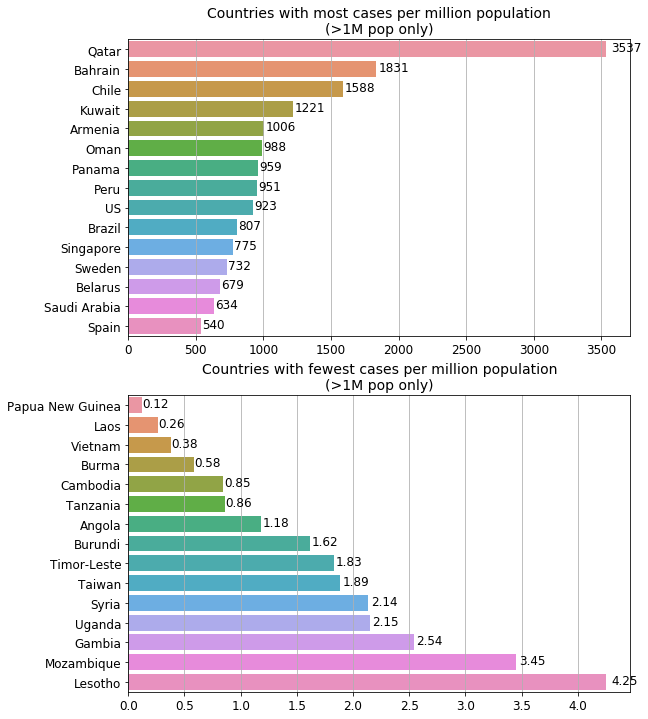

In [54]:
def plot_pop_case(rank, title):
    if rank == 'highest':
        _ = cty_p[cty_p.Population>1000000].sort_values('Case per M pop', ascending=False).head(15)
    else:
        _ = cty_p[cty_p.Population>1000000].sort_values('Case per M pop').head(15)
    g = sns.barplot(_['Case per M pop'], _.Country)
    plt.title(title, fontsize=14)
    plt.ylabel(None)
    plt.xlabel(None)
    plt.grid(axis='x')
    if rank == 'highest':
        for i, v in enumerate(_['Case per M pop']):
            g.text(v*1.01, i+0.1, str(int(v)))
    else:
        for i, v in enumerate(_['Case per M pop']):
            g.text(v*1.01, i+0.1, str(round(v,2)))

plt.figure(figsize=(9,12))
plt.subplot(211)
plot_pop_case('highest','Countries with most cases per million population\n(>1M pop only)')
plt.subplot(212)
plot_pop_case('lowest','Countries with fewest cases per million population\n(>1M pop only)')


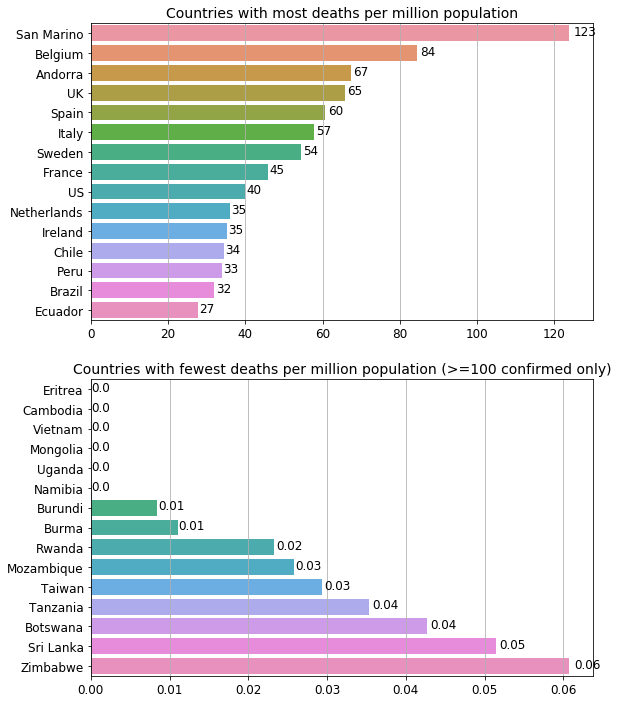

In [57]:
def plot_pop_death(rank, title):
    if rank == 'highest':
        _ = cty_p.sort_values('Death per M pop', ascending=False).head(15)
    else:
        _ = cty_p[cty_p.Confirmed>=100].sort_values('Death per M pop').head(15)
    g = sns.barplot(_['Death per M pop'], _.Country)
    plt.title(title, fontsize=14)
    plt.ylabel(None)
    plt.xlabel(None)
    plt.grid(axis='x')
    if rank == 'highest':
        for i, v in enumerate(_['Death per M pop']):
            g.text(v*1.01, i+0.1, str(int(v)))
    else:
        for i, v in enumerate(_['Death per M pop']):
            g.text(v*1.01, i+0.1, str(round(v,2)))

plt.figure(figsize=(9,12))
plt.subplot(211)
plot_pop_death('highest','Countries with most deaths per million population')
plt.subplot(212)
plot_pop_death('lowest','Countries with fewest deaths per million population (>=100 confirmed only)')